### Chatbot with RAG

In [61]:
# !pip install langchain
# !pip install torch
# !pip install transformers
# !pip install faiss-cpu
# !pip install pypdf
# !pip install sentence-transformers

# !pip install langchain_nvidia_trt
# !pip install tqdm transformers spacy datasets langchain_text_splitters langchain-chroma sentence_transformers
# !pip install langchain langchain_community transformers langchain-huggingface
# !pip install datasets 
# !pip install "unstructured[pdf]"
# !pip install nltk
# !pip install pymilvus


In [94]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from langchain_huggingface import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
from langchain.schema import Document
from langchain.document_loaders import PyPDFLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re


In [95]:
pdfLoader = PyPDFLoader("Large_language_model.pdf")
documents = pdfLoader.load()

In [96]:
# Function to remove punctuation from text
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

In [97]:
# Step 1: Clean the documents
cleaned_documents = []
for doc in documents:
    cleaned_text = remove_punctuation(doc.page_content)
    cleaned_documents.append(
        Document(page_content=cleaned_text, metadata=doc.metadata)
    )

In [171]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=150)
docs = text_splitter.split_documents(cleaned_documents)
print(docs[:2])

[Document(page_content='A Comprehensive Overview of Large Language Models\nHumza Naveeda Asad Ullah Khana Shi Qiub Muhammad Saqibcd Saeed Anwaref Muhammad Usmanef Naveed Akhtargi\nNick Barnesh Ajmal Miani\naUniversity of Engineering and Technology UET Lahore Pakistan\nbThe Chinese University of Hong Kong CUHK HKSAR China\ncUniversity of Technology Sydney UTS Sydney Australia\ndCommonwealth Scientific and Industrial Research Organisation CSIRO Sydney Australia\neKing Fahd University of Petroleum and Minerals KFUPM Dhahran Saudi Arabia', metadata={'source': 'Large_language_model.pdf', 'page': 0}), Document(page_content='eKing Fahd University of Petroleum and Minerals KFUPM Dhahran Saudi Arabia\nfSDAIAKFUPM Joint Research Center for Artificial Intelligence JRCAI Dhahran Saudi Arabia\ngThe University of Melbourne UoM Melbourne Australia\nhAustralian National University ANU Canberra Australia\niThe University of Western Australia UWA Perth Australia\nAbstract\nLarge Language Models LLMs hav

In [172]:
# Step 2: Create embeddings for the documents
model_path = "sentence-transformers/all-MiniLM-L6-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
embeddings = HuggingFaceEmbeddings(
    model_name=model_path,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)


C:\Users\dhira\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [173]:
from langchain.vectorstores import FAISS

# Step 3: Create a FAISS vector store from the documents and embeddings
db = FAISS.from_documents(docs, embeddings)


Shape of embeddings: (684, 384)
Sample embeddings:
[[ 0.01232496 -0.02679825  0.04811481 ...  0.02733993  0.0265749
   0.00485345]
 [ 0.02791672 -0.09564687  0.08215802 ...  0.00785274 -0.01675238
  -0.02965456]
 [ 0.06489174 -0.1466633   0.05253063 ...  0.04571626 -0.0797215
   0.04547737]
 [ 0.05104927 -0.12040755  0.02715064 ... -0.00262838 -0.09942228
   0.03566477]
 [ 0.08482441 -0.08018138  0.0404528  ... -0.06145912 -0.03181734
   0.01931041]]


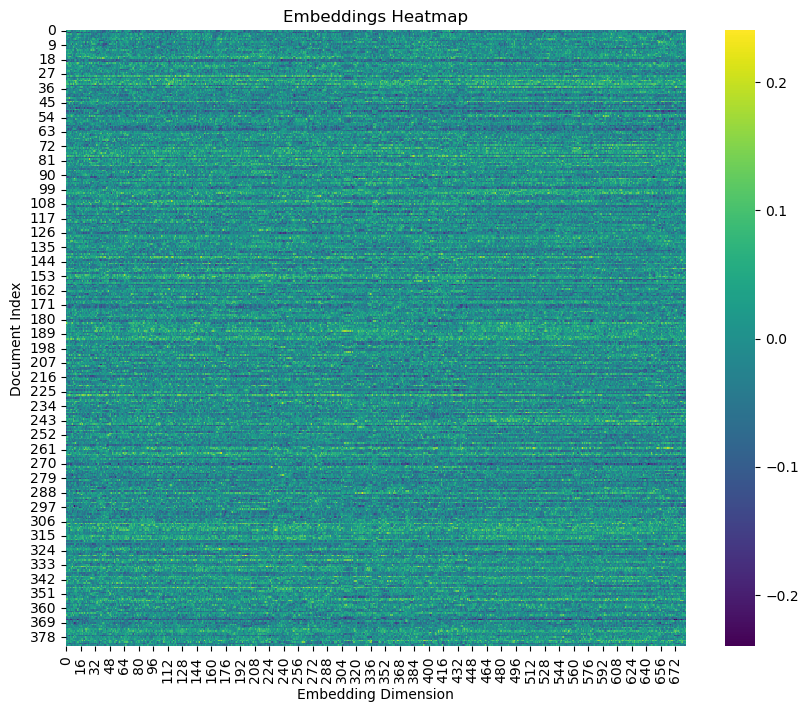

In [174]:
# Step 12: Inspect and visualize embeddings
def inspect_embeddings(db):
    # Extracting embeddings
    index = db.index
    embeddings = index.reconstruct_n(0, index.ntotal)
    
    # Check the shape and some values
    print(f"Shape of embeddings: {embeddings.shape}")
    print(f"Sample embeddings:\n{embeddings[:5]}")
    
    # Visualize embeddings
    plt.figure(figsize=(10, 8))
    sns.heatmap(embeddings.T, cmap="viridis")
    plt.title("Embeddings Heatmap")
    plt.xlabel("Embedding Dimension")
    plt.ylabel("Document Index")
    plt.show()

inspect_embeddings(db)

In [180]:
# Step 4: Define the question
question = "How can fine tune a pre trained llm?"

In [181]:
searchDocs = db.similarity_search(question)
print(searchDocs[0].page_content)

Figure 3 A broader overview of LLMs dividing LLMs into seven branches 1 PreTraining 2 FineTuning 3 E fficient 4 Inference 5 Evaluation 6 Applications
7 Challenges
hensively including background pretraining finetuning
multimodal LLMs augmented LLMs LLMspowered
agents datasets evaluation etc
We loosely follow the existing terminology to ensure a stan
dardized outlook of this research direction For instance fol
lowing 50 our survey discusses pretrained LLMs with 10B


In [187]:
# Step 6: Create a HuggingFace pipeline for text generation
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small")

pipe = pipeline(
    "text2text-generation", 
    model=model, 
    tokenizer=tokenizer, 
    max_length=512, 
    truncation=True, 
    max_new_tokens=100
)


In [188]:
# Step 7: Wrap the pipeline in HuggingFacePipeline
llm = HuggingFacePipeline(
    pipeline=pipe,
    model_kwargs={"temperature": 0, "max_length": 512}
)

In [189]:
# Step 8: Define the QA prompt template
template = """Please utilize the context provided below to formulate a well-informed response to the question posed at the end. If uncertain about the answer, simply acknowledge it rather than speculating. Aim for clarity and conciseness in your response.

Context:
{context}

Question: {question}

Detailed Answer:
"""
QA_CHAIN_PROMPT = PromptTemplate.from_template(template)



In [190]:
# Step 9: Create the RetrievalQA chain
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=db.as_retriever(),
    chain_type_kwargs={"prompt": QA_CHAIN_PROMPT}
)

In [191]:
# Step 10: Use the chain to answer the question with retrieved documents as context
result = qa_chain({"query": question})

Both `max_new_tokens` (=100) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


In [192]:
# Print the answer generated by the LLM
print(result["result"])

Using RAG.


In [193]:
question2 = "Can I install LLM into my local system?"
result = qa_chain({"query": question2})
print(result["result"])

Both `max_new_tokens` (=100) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Yes, it is.
